In [59]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import concurrent.futures

In [60]:
def get_time_series():
    API_key = 'MCO3JQL81ATB1YZ0'
    time = TimeSeries(key = API_key,output_format='pandas')
    return time

In [61]:
def average(lst): #calculates and returns mean of a list
    if len(lst):
        return sum(lst) / len(lst)
    else:
        return sum(lst)

In [62]:
def get_data_frame(ticker, cash, vwap=0, twap=0):
    time = get_time_series()
    data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')
    df = data[0]
    df = df.rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})
    result = [group[1] for group in df.groupby(df.index.day)]
    
    for index, dataframe in enumerate(result):
        index += 1
        
        dataframe = dataframe.loc[(dataframe.index.hour >= 9)]
        dataframe = dataframe.loc[(dataframe.index.hour <= 15)]
        dataframe = dataframe.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
        
        
        if vwap:    
            dataframe['VWAP'] = (((dataframe['High']+dataframe['Low']+dataframe['Close'])*dataframe['Volume']/3).cumsum())/dataframe['Volume'].cumsum()
        if twap:
            df_open = dataframe['Open'].tolist()
            df_high = dataframe['High'].tolist()
            df_low = dataframe['Low'].tolist()
            df_close = dataframe['Close'].tolist()
            
            new_list = []
            
            
            for i in range(0, len(df_open)):
                twap_data = (average(df_open[0:i])+average(df_high[0:i])+average(df_low[0:i])+average(df_close[0:i]))/4
                new_list.append(twap_data)
            
            new_list[0] = df_open[0]
            
            
            dataframe['TWAP'] = new_list
            
        
        dataframe = dataframe.dropna()
        
        
        #print(dataframe['TWAP'].tolist())
        #print(dataframe['TWAP'])
        #type(dataframe['TWAP'])
        yield dataframe
     



In [63]:
def plot_data_frame(ticker, cash, add_vwap=0, add_twap=0): # by default, add_vwap and add_twap are false
    
    #generator object
    dataframe= get_data_frame(ticker, cash, add_vwap, add_twap)
    
    #loops through dataframe for each day
    for df in dataframe:
        #print(df)
        #plots is a list of our mpf plots
        plots = []
        
        if add_vwap:
            vwap = mpf.make_addplot(df['VWAP'])
            #plots.append(vwap)
        
        if add_twap:
            twap = mpf.make_addplot(df['TWAP'])
            plots.append(twap)
            
        #plot charts
        mpf.plot(df,addplot=plots,type='candle',style='yahoo',volume=True,title=f"{df.index.date[0]} {ticker}")
        
        #Strategies Go Here
        twap_strategy(0, 60, 3, 6, df['TWAP'].tolist(), df['Open'].tolist()) #first 60 minutes, execute over three periods, pass vwap list, df
    

In [64]:
#start and end define the specified time period
#nbuckets tells how many buckets to divide trade into
#ntrades is how many trades we want to make over the time period
#t_list is the list of TWAP data 
#df is the entire dataframe
def twap_strategy(start, end, nbuckets, ntrades, t_list, o_list): 
    #print start and end TWAP values for period
    print(f"Period's starting TWAP value: {time_retrieve(t_list,start)}")
    print(f"Period's ending TWAP value: {time_retrieve(t_list,end)}")
    
    trades_per_bucket = ntrades/nbuckets
    timediff = end-start

    #
    b_start = start #
    b_end = start + timediff/nbuckets #marks end of bucket period
    
    #buys
    for bucket in range(nbuckets):
        for trade in range(int(trades_per_bucket)):
            for time in range(int(b_start), int(b_end), 5): #increment through 5 minute intervals
                if(time_retrieve(t_list,time) <= time_retrieve(o_list,start)):
                    print(f'Purchased one share for {time_retrieve(o_list,time)}')
                    continue
        b_start = b_start + timediff/nbuckets
        b_end = b_end + timediff/nbuckets

In [65]:
def multi(ticker, cash, cores, add_vwap=0, add_twap=0):
    
    with concurrent.futures.ProcessPoolExecutor(cores) as executor:
        
        return plot_data_frame(ticker, cash, add_vwap, add_twap)

In [66]:
def timetolist(time): 
    #function converts a time in minutes to integer to reference list where elements are stored in 5 min intervals    
    return time/5

In [67]:
def time_retrieve(l, time): #where l is a list, time is time in minutes (from 9:00), 
    #fxn returns value from list
    return l[int(timetolist(time))]

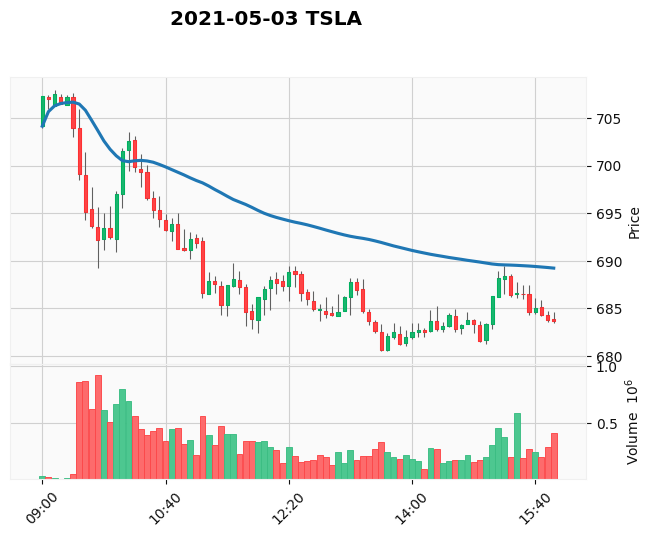

Period's starting TWAP value: 704.16
Period's ending TWAP value: 701.0482708333334
Purchased one share for 704.16
Purchased one share for 704.16
Purchased one share for 693.61
Purchased one share for 692.31
Purchased one share for 693.475
Purchased one share for 693.61
Purchased one share for 692.31
Purchased one share for 693.475


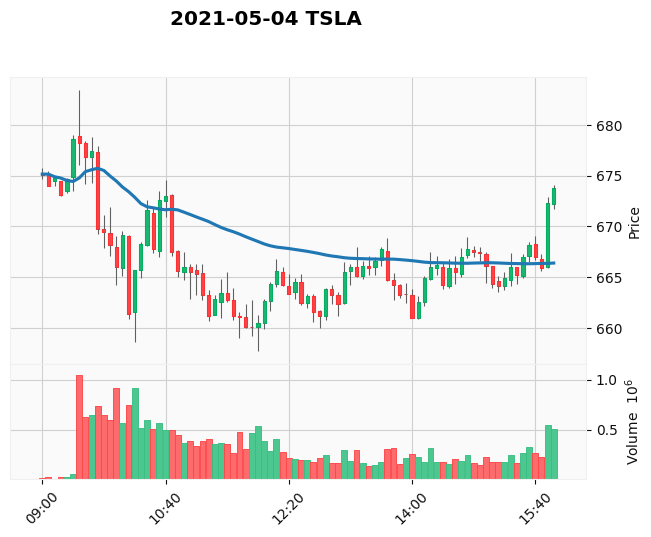

Period's starting TWAP value: 675.15
Period's ending TWAP value: 674.4720562499999
Purchased one share for 675.15
Purchased one share for 675.02
Purchased one share for 674.45
Purchased one share for 674.4999
Purchased one share for 675.15
Purchased one share for 675.02
Purchased one share for 674.45
Purchased one share for 674.4999
Purchased one share for 673.44
Purchased one share for 674.9
Purchased one share for 678.87
Purchased one share for 673.44
Purchased one share for 674.9
Purchased one share for 678.87
Purchased one share for 669.32
Purchased one share for 669.32


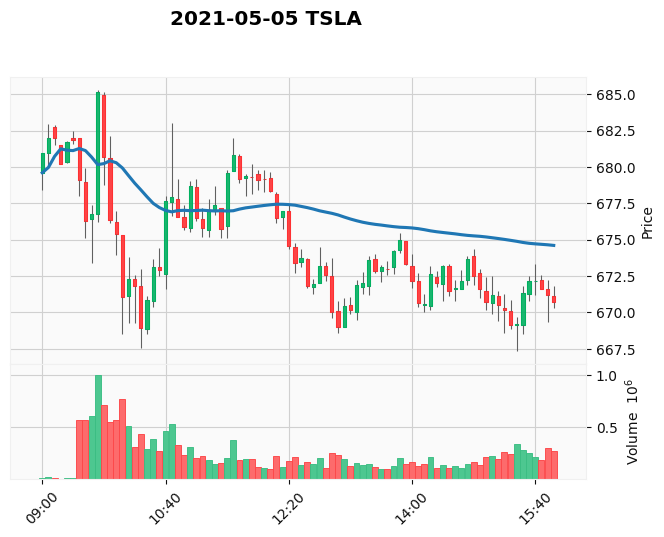

Period's starting TWAP value: 679.6
Period's ending TWAP value: 680.2881749999999
Purchased one share for 679.6
Purchased one share for 679.6


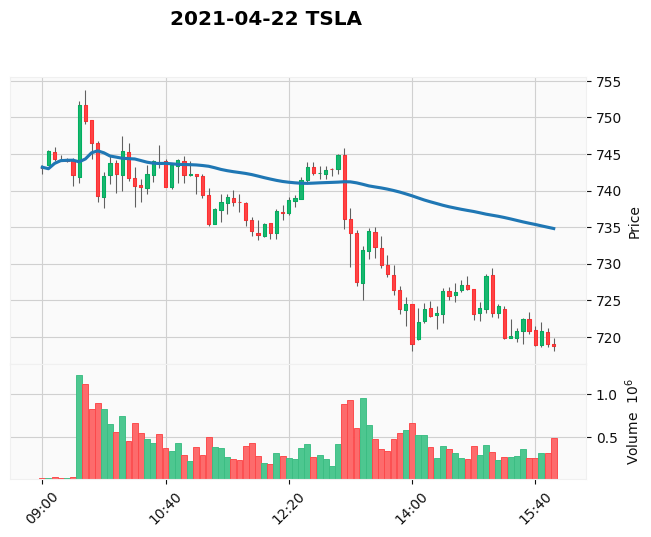

Period's starting TWAP value: 743.19
Period's ending TWAP value: 744.572525
Purchased one share for 743.19
Purchased one share for 743.45
Purchased one share for 743.19
Purchased one share for 743.45


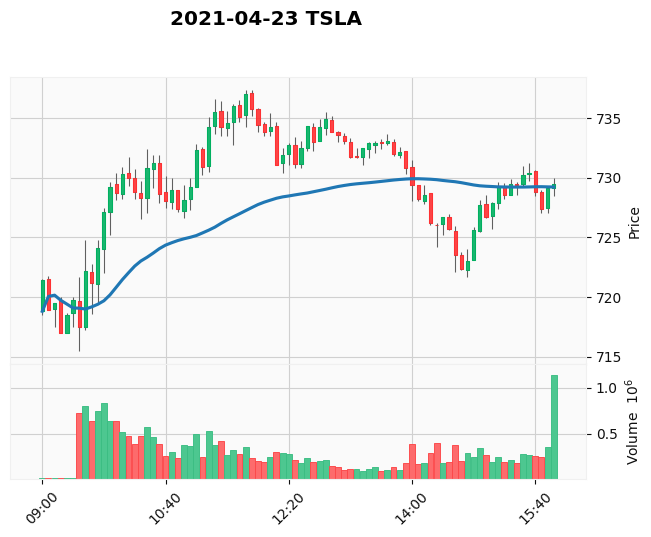

Period's starting TWAP value: 718.8
Period's ending TWAP value: 720.8175041666666
Purchased one share for 718.8
Purchased one share for 718.8


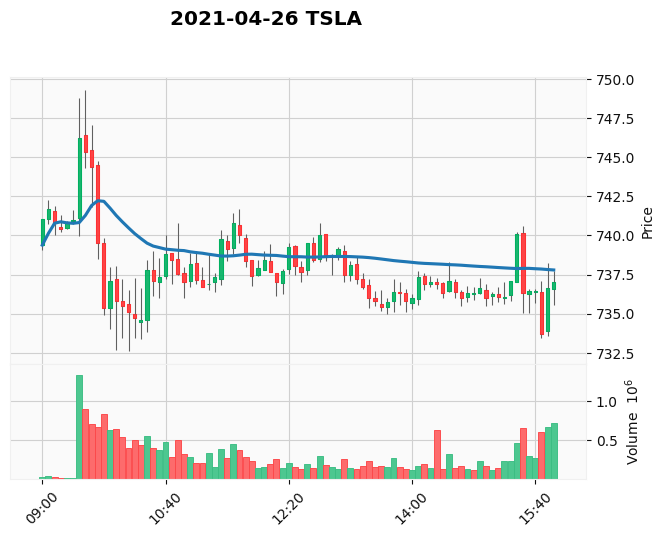

Period's starting TWAP value: 739.38
Period's ending TWAP value: 741.2762937499999
Purchased one share for 739.38
Purchased one share for 739.38


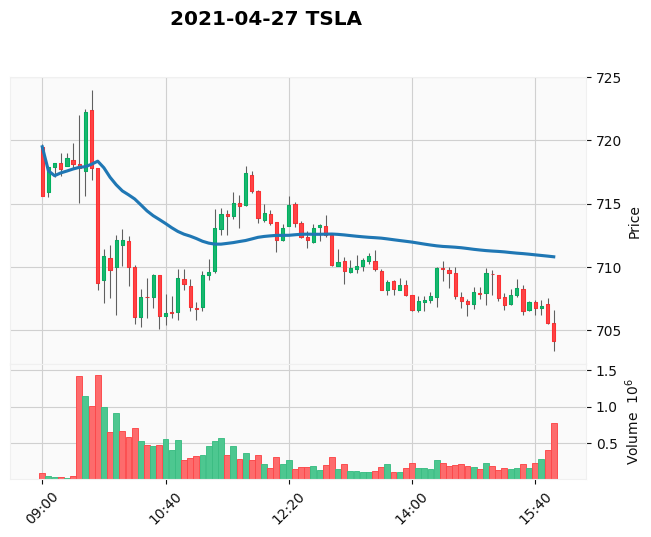

Period's starting TWAP value: 719.5
Period's ending TWAP value: 716.4972916666667
Purchased one share for 719.5
Purchased one share for 715.94
Purchased one share for 717.9
Purchased one share for 718.22
Purchased one share for 719.5
Purchased one share for 715.94
Purchased one share for 717.9
Purchased one share for 718.22
Purchased one share for 717.99
Purchased one share for 718.45
Purchased one share for 718.12
Purchased one share for 717.6001
Purchased one share for 717.99
Purchased one share for 718.45
Purchased one share for 718.12
Purchased one share for 717.6001
Purchased one share for 722.43
Purchased one share for 717.81
Purchased one share for 708.9999
Purchased one share for 710.7001
Purchased one share for 722.43
Purchased one share for 717.81
Purchased one share for 708.9999
Purchased one share for 710.7001


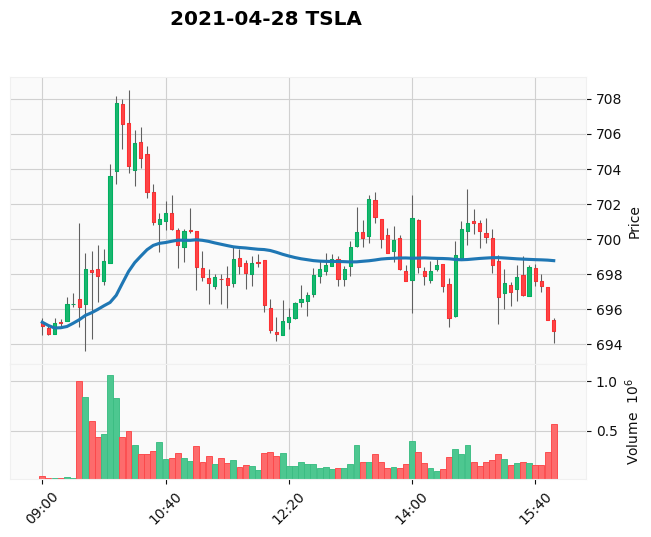

Period's starting TWAP value: 695.25
Period's ending TWAP value: 696.7870541666667
Purchased one share for 695.25
Purchased one share for 694.95
Purchased one share for 694.6
Purchased one share for 695.25
Purchased one share for 695.25
Purchased one share for 694.95
Purchased one share for 694.6
Purchased one share for 695.25
Purchased one share for 695.35
Purchased one share for 696.3
Purchased one share for 695.35
Purchased one share for 696.3


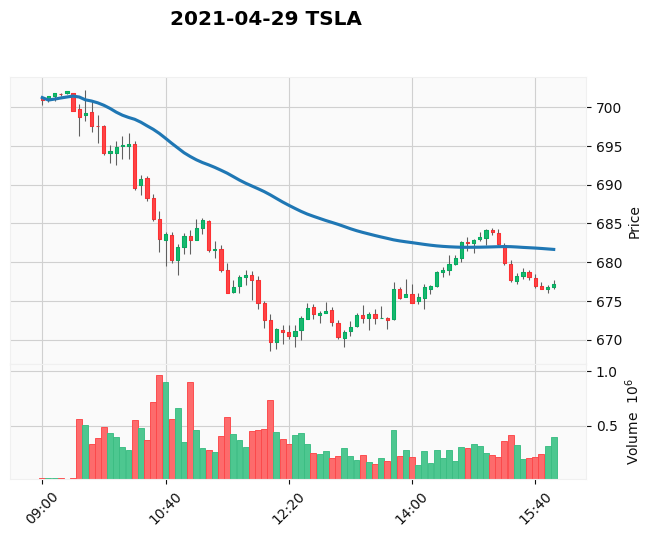

Period's starting TWAP value: 701.25
Period's ending TWAP value: 699.3693375
Purchased one share for 701.25
Purchased one share for 701.0
Purchased one share for 701.48
Purchased one share for 701.73
Purchased one share for 701.25
Purchased one share for 701.0
Purchased one share for 701.48
Purchased one share for 701.73
Purchased one share for 699.04
Purchased one share for 699.04
Purchased one share for 699.45
Purchased one share for 697.605
Purchased one share for 697.59
Purchased one share for 694.09
Purchased one share for 699.45
Purchased one share for 697.605
Purchased one share for 697.59
Purchased one share for 694.09


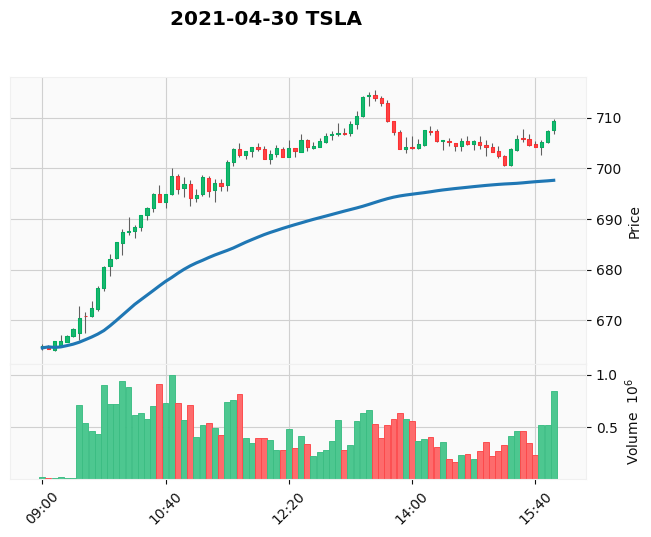

Period's starting TWAP value: 664.55
Period's ending TWAP value: 669.9402020833334
Purchased one share for 664.55
Purchased one share for 664.55


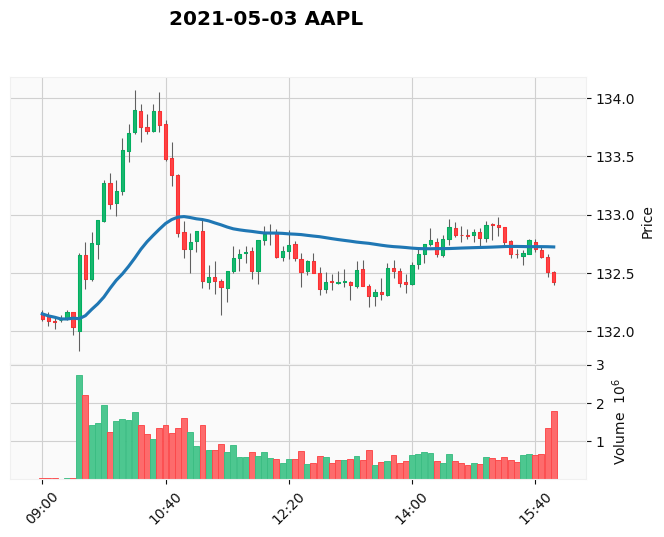

Period's starting TWAP value: 132.15
Period's ending TWAP value: 132.4374208333333
Purchased one share for 132.15
Purchased one share for 132.13
Purchased one share for 132.09
Purchased one share for 132.099
Purchased one share for 132.15
Purchased one share for 132.13
Purchased one share for 132.09
Purchased one share for 132.099
Purchased one share for 132.11
Purchased one share for 132.17
Purchased one share for 132.0
Purchased one share for 132.655
Purchased one share for 132.11
Purchased one share for 132.17
Purchased one share for 132.0
Purchased one share for 132.655


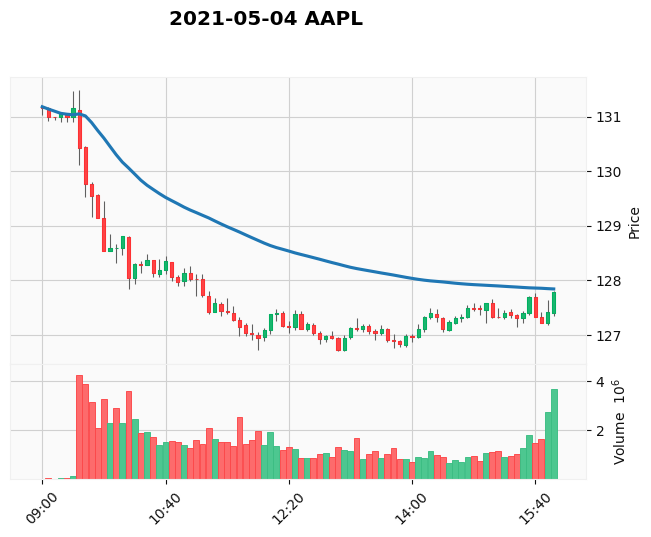

Period's starting TWAP value: 131.18
Period's ending TWAP value: 130.30027291666667
Purchased one share for 131.18
Purchased one share for 131.15
Purchased one share for 131.0
Purchased one share for 130.99
Purchased one share for 131.18
Purchased one share for 131.15
Purchased one share for 131.0
Purchased one share for 130.99
Purchased one share for 131.03
Purchased one share for 131.0
Purchased one share for 131.12
Purchased one share for 130.44
Purchased one share for 131.03
Purchased one share for 131.0
Purchased one share for 131.12
Purchased one share for 130.44
Purchased one share for 129.77
Purchased one share for 129.5586
Purchased one share for 129.15
Purchased one share for 128.54
Purchased one share for 129.77
Purchased one share for 129.5586
Purchased one share for 129.15
Purchased one share for 128.54


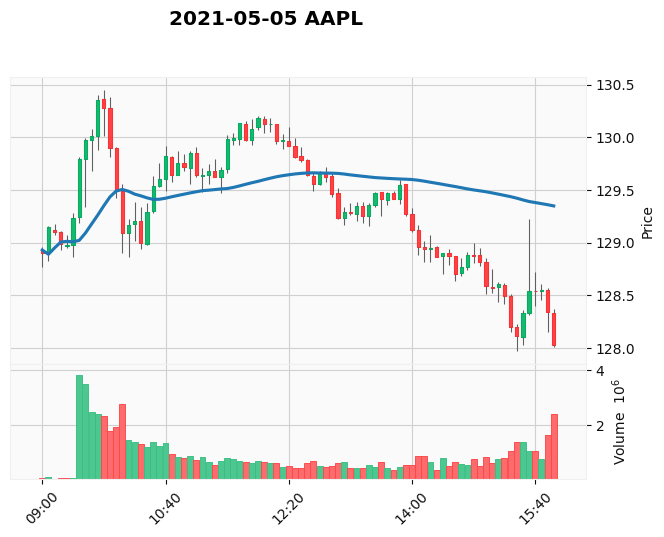

Period's starting TWAP value: 128.93
Period's ending TWAP value: 129.49008958333334
Purchased one share for 128.93
Purchased one share for 128.9
Purchased one share for 128.93
Purchased one share for 128.9


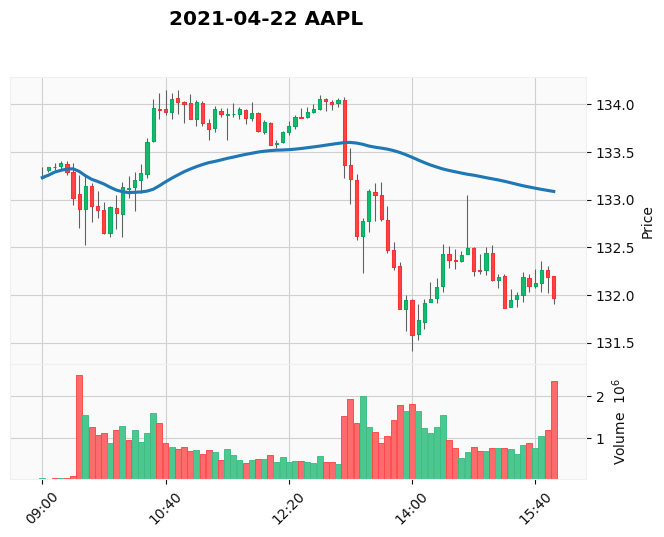

Period's starting TWAP value: 133.23
Period's ending TWAP value: 133.09968750000002
Purchased one share for 133.23
Purchased one share for 133.23
Purchased one share for 133.14
Purchased one share for 132.93
Purchased one share for 132.89
Purchased one share for 132.65
Purchased one share for 133.14
Purchased one share for 132.93
Purchased one share for 132.89
Purchased one share for 132.65


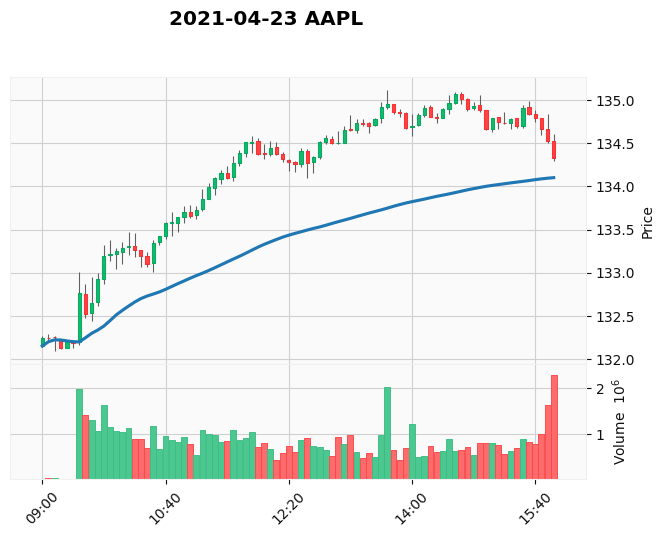

Period's starting TWAP value: 132.15
Period's ending TWAP value: 132.5106375
Purchased one share for 132.15
Purchased one share for 132.15


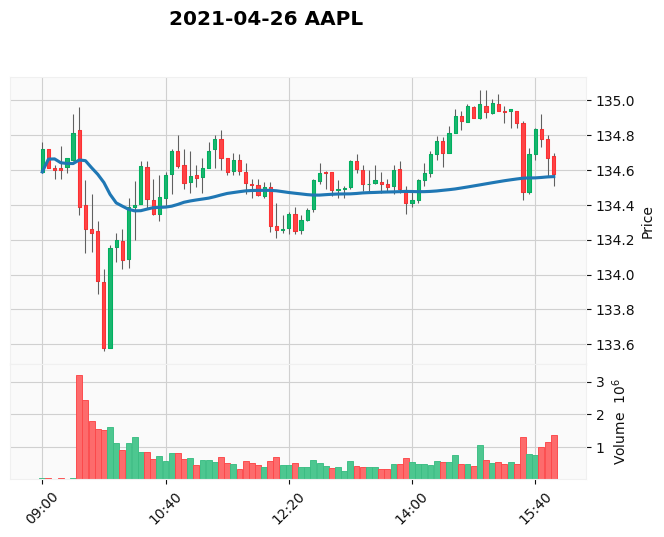

Period's starting TWAP value: 134.589
Period's ending TWAP value: 134.41118333333333
Purchased one share for 134.589
Purchased one share for 134.589
Purchased one share for 134.25
Purchased one share for 133.96
Purchased one share for 133.5801
Purchased one share for 134.25
Purchased one share for 133.96
Purchased one share for 133.5801


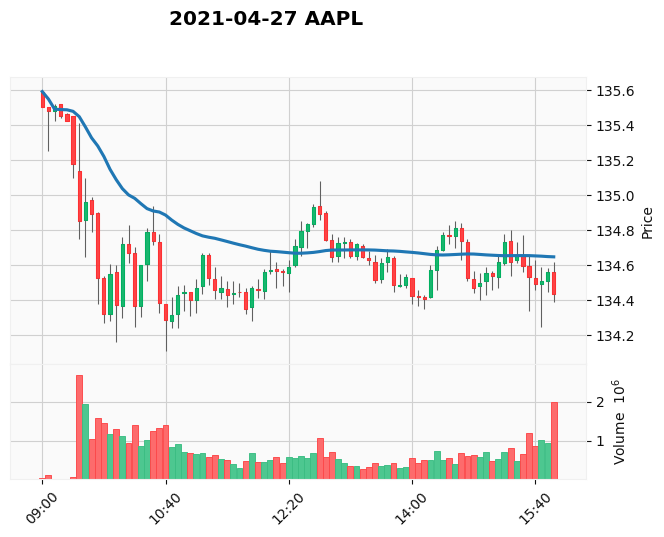

Period's starting TWAP value: 135.59
Period's ending TWAP value: 135.08782499999998
Purchased one share for 135.59
Purchased one share for 135.5
Purchased one share for 135.48
Purchased one share for 135.52
Purchased one share for 135.59
Purchased one share for 135.5
Purchased one share for 135.48
Purchased one share for 135.52
Purchased one share for 135.46
Purchased one share for 135.45
Purchased one share for 135.14
Purchased one share for 134.86
Purchased one share for 135.46
Purchased one share for 135.45
Purchased one share for 135.14
Purchased one share for 134.86
Purchased one share for 134.97
Purchased one share for 134.9
Purchased one share for 134.525
Purchased one share for 134.32
Purchased one share for 134.97
Purchased one share for 134.9
Purchased one share for 134.525
Purchased one share for 134.32


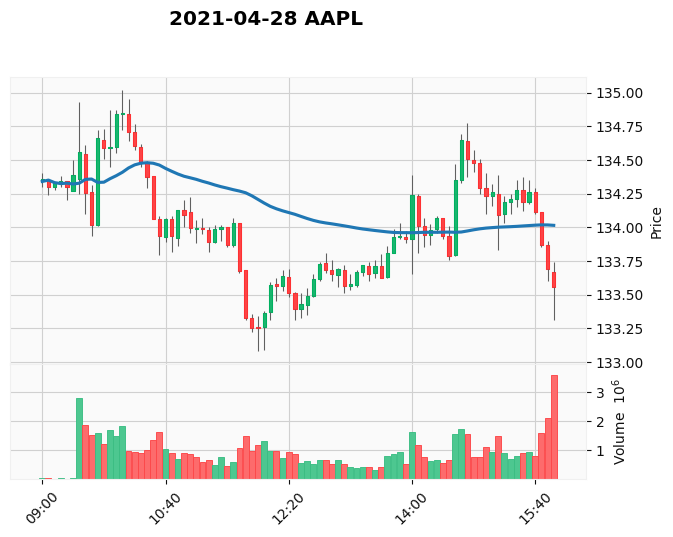

Period's starting TWAP value: 134.34
Period's ending TWAP value: 134.38260416666668
Purchased one share for 134.34
Purchased one share for 134.3
Purchased one share for 134.33
Purchased one share for 134.34
Purchased one share for 134.3
Purchased one share for 134.33
Purchased one share for 134.34
Purchased one share for 134.27
Purchased one share for 134.36
Purchased one share for 134.34
Purchased one share for 134.27
Purchased one share for 134.36
Purchased one share for 134.0201
Purchased one share for 134.65
Purchased one share for 134.0201
Purchased one share for 134.65


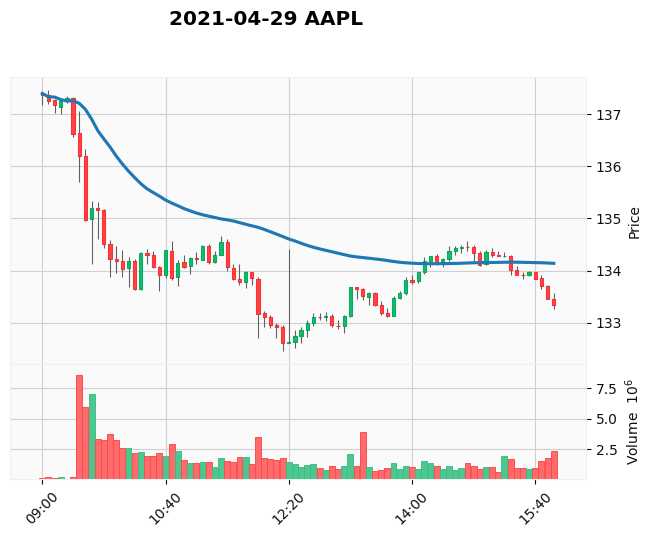

Period's starting TWAP value: 137.4
Period's ending TWAP value: 136.19904375
Purchased one share for 137.4
Purchased one share for 137.37
Purchased one share for 137.27
Purchased one share for 137.14
Purchased one share for 137.4
Purchased one share for 137.37
Purchased one share for 137.27
Purchased one share for 137.14
Purchased one share for 137.25
Purchased one share for 137.32
Purchased one share for 136.64
Purchased one share for 136.1999
Purchased one share for 137.25
Purchased one share for 137.32
Purchased one share for 136.64
Purchased one share for 136.1999
Purchased one share for 134.98
Purchased one share for 135.21
Purchased one share for 135.16
Purchased one share for 134.5085
Purchased one share for 134.98
Purchased one share for 135.21
Purchased one share for 135.16
Purchased one share for 134.5085


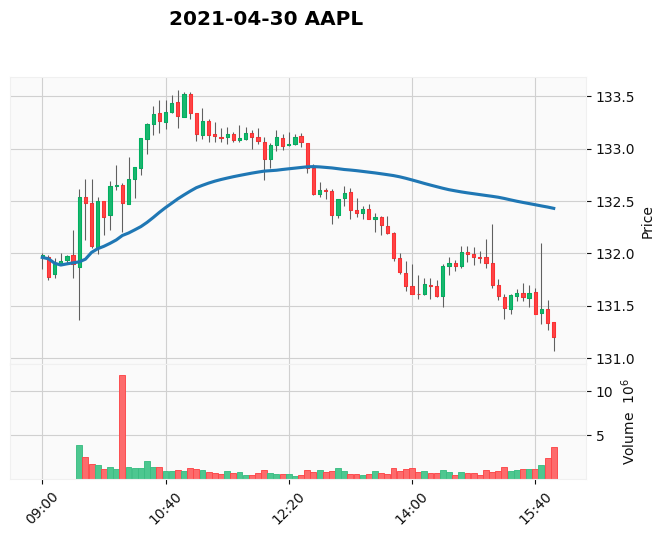

Period's starting TWAP value: 131.96
Period's ending TWAP value: 132.12682916666665
Purchased one share for 131.96
Purchased one share for 131.96
Purchased one share for 131.8
Purchased one share for 131.9
Purchased one share for 131.96
Purchased one share for 131.96
Purchased one share for 131.8
Purchased one share for 131.9
Purchased one share for 131.94
Purchased one share for 131.98
Purchased one share for 131.87
Purchased one share for 132.54
Purchased one share for 131.94
Purchased one share for 131.98
Purchased one share for 131.87
Purchased one share for 132.54


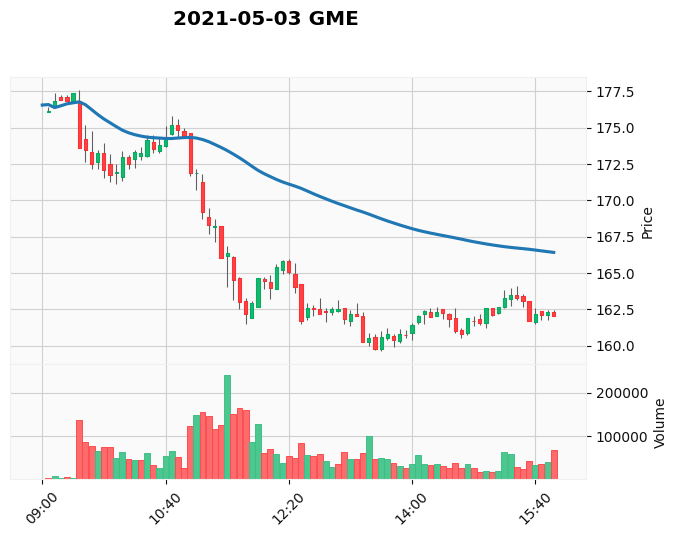

Period's starting TWAP value: 176.55
Period's ending TWAP value: 175.0693229166667
Purchased one share for 176.55
Purchased one share for 176.4
Purchased one share for 177.1
Purchased one share for 176.55
Purchased one share for 176.4
Purchased one share for 177.1
Purchased one share for 173.3
Purchased one share for 172.605
Purchased one share for 173.256
Purchased one share for 172.5
Purchased one share for 173.3
Purchased one share for 172.605
Purchased one share for 173.256
Purchased one share for 172.5


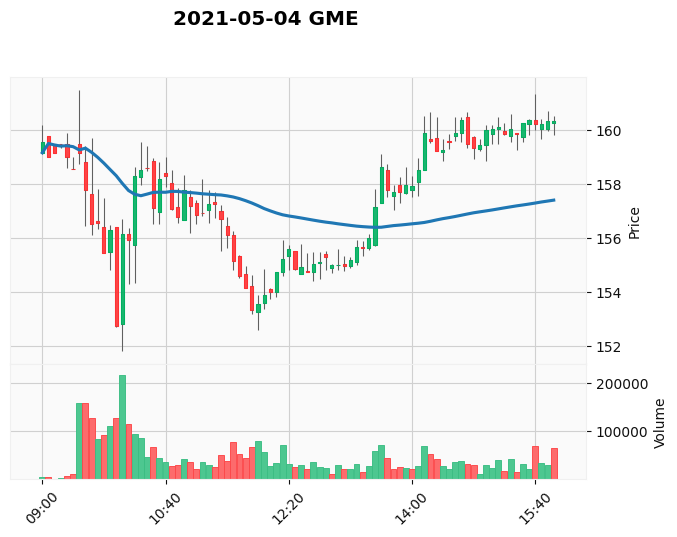

Period's starting TWAP value: 159.16
Period's ending TWAP value: 158.30622083333333
Purchased one share for 159.16
Purchased one share for 159.16
Purchased one share for 156.63
Purchased one share for 156.4
Purchased one share for 155.47
Purchased one share for 156.63
Purchased one share for 156.4
Purchased one share for 155.47


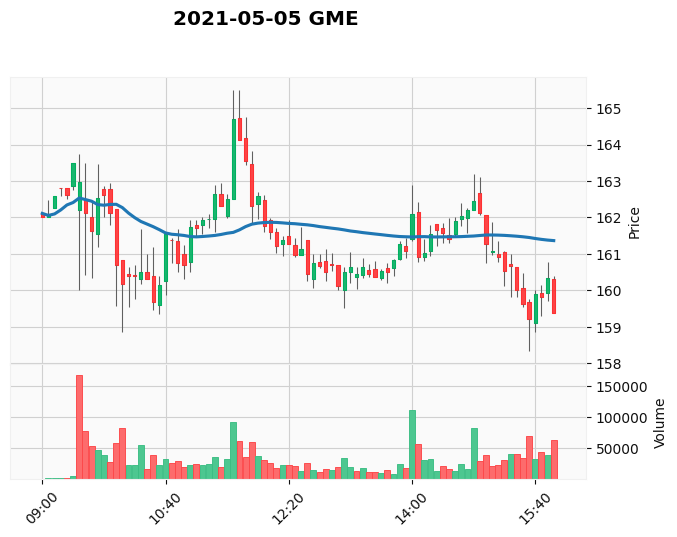

Period's starting TWAP value: 162.11
Period's ending TWAP value: 162.36023125000003
Purchased one share for 162.11
Purchased one share for 162.0
Purchased one share for 162.25
Purchased one share for 162.11
Purchased one share for 162.0
Purchased one share for 162.25


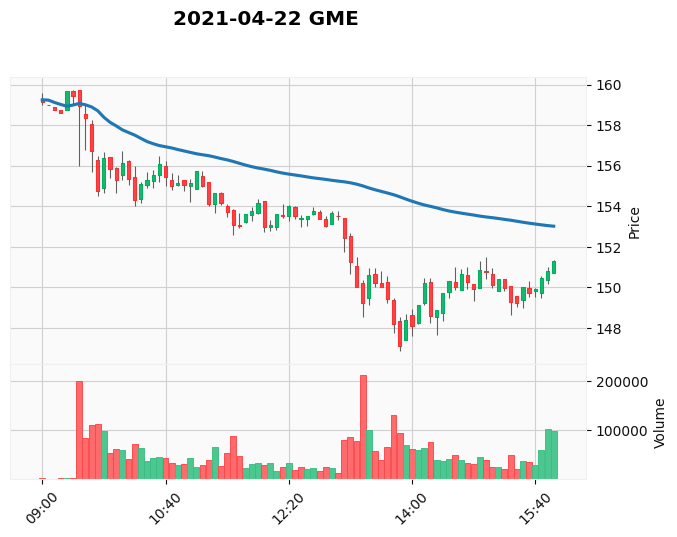

Period's starting TWAP value: 159.25
Period's ending TWAP value: 157.96207916666665
Purchased one share for 159.25
Purchased one share for 159.0
Purchased one share for 158.9
Purchased one share for 158.74
Purchased one share for 159.25
Purchased one share for 159.0
Purchased one share for 158.9
Purchased one share for 158.74
Purchased one share for 158.75
Purchased one share for 159.68
Purchased one share for 159.74
Purchased one share for 158.53
Purchased one share for 158.75
Purchased one share for 159.68
Purchased one share for 159.74
Purchased one share for 158.53
Purchased one share for 158.0463
Purchased one share for 156.27
Purchased one share for 154.88
Purchased one share for 156.41
Purchased one share for 158.0463
Purchased one share for 156.27
Purchased one share for 154.88
Purchased one share for 156.41


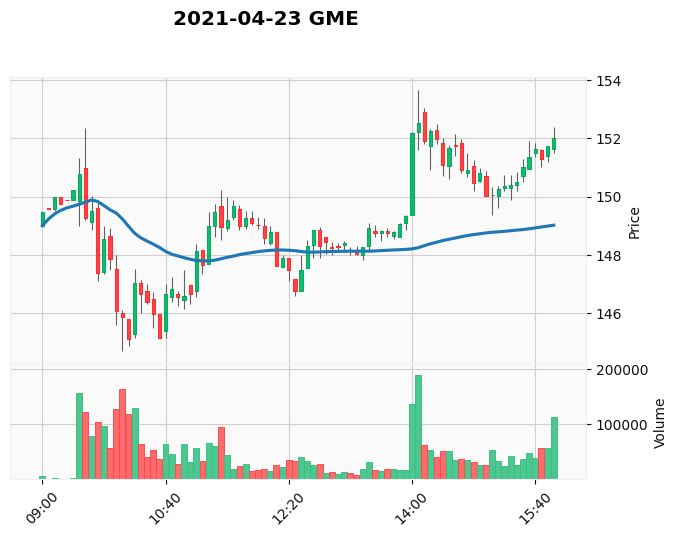

Period's starting TWAP value: 149.0
Period's ending TWAP value: 149.43767291666666
Purchased one share for 149.0
Purchased one share for 149.0


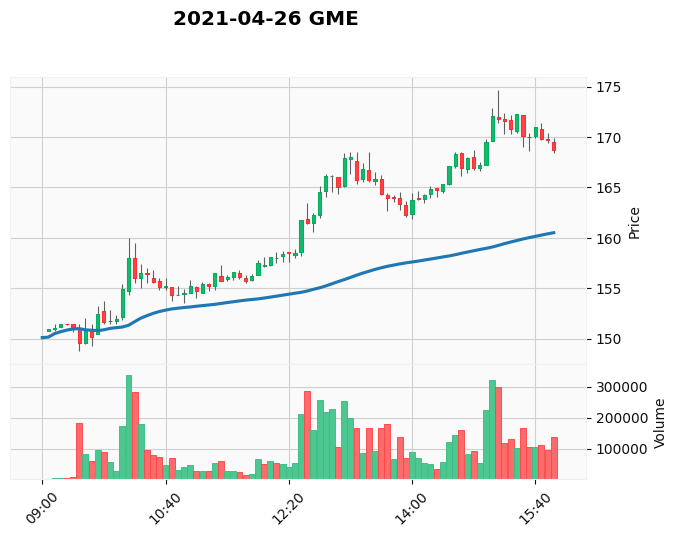

Period's starting TWAP value: 150.1
Period's ending TWAP value: 151.0964125
Purchased one share for 150.1
Purchased one share for 150.1


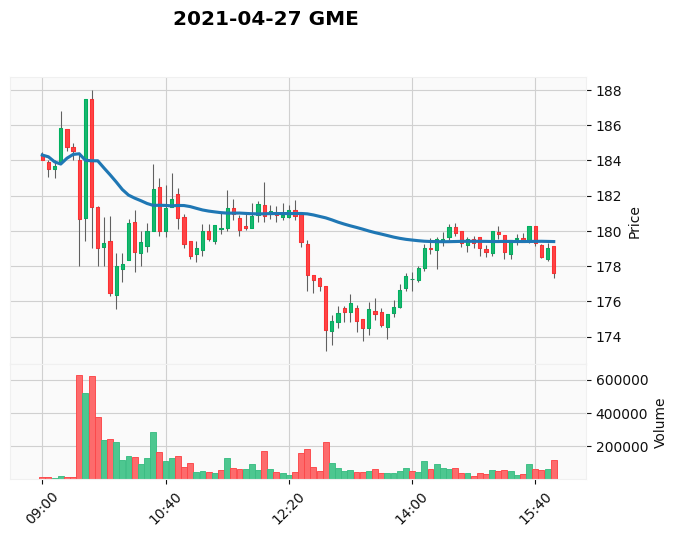

Period's starting TWAP value: 184.3
Period's ending TWAP value: 182.77314375
Purchased one share for 184.3
Purchased one share for 183.9
Purchased one share for 183.5
Purchased one share for 183.9
Purchased one share for 184.3
Purchased one share for 183.9
Purchased one share for 183.5
Purchased one share for 183.9
Purchased one share for 185.76
Purchased one share for 180.73
Purchased one share for 185.76
Purchased one share for 180.73
Purchased one share for 187.48
Purchased one share for 181.37
Purchased one share for 179.09
Purchased one share for 179.45
Purchased one share for 187.48
Purchased one share for 181.37
Purchased one share for 179.09
Purchased one share for 179.45


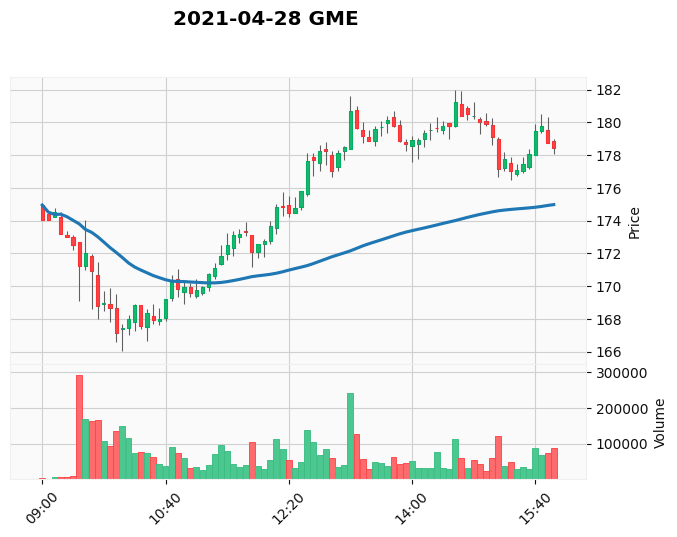

Period's starting TWAP value: 174.95
Period's ending TWAP value: 172.05633125000003
Purchased one share for 174.95
Purchased one share for 174.43
Purchased one share for 174.22
Purchased one share for 174.2
Purchased one share for 174.95
Purchased one share for 174.43
Purchased one share for 174.22
Purchased one share for 174.2
Purchased one share for 173.15
Purchased one share for 173.0
Purchased one share for 172.69
Purchased one share for 171.25
Purchased one share for 173.15
Purchased one share for 173.0
Purchased one share for 172.69
Purchased one share for 171.25
Purchased one share for 171.82
Purchased one share for 170.7
Purchased one share for 168.91
Purchased one share for 168.9
Purchased one share for 171.82
Purchased one share for 170.7
Purchased one share for 168.91
Purchased one share for 168.9


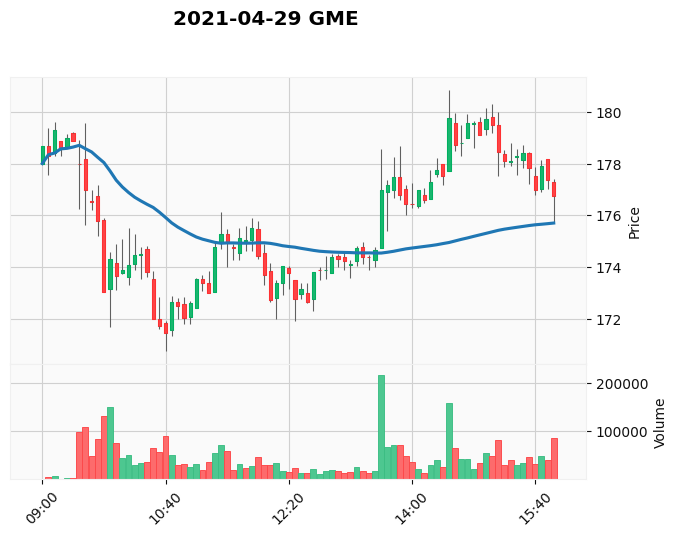

Period's starting TWAP value: 178.01
Period's ending TWAP value: 177.36448125
Purchased one share for 178.01
Purchased one share for 178.01
Purchased one share for 173.1459
Purchased one share for 173.1459


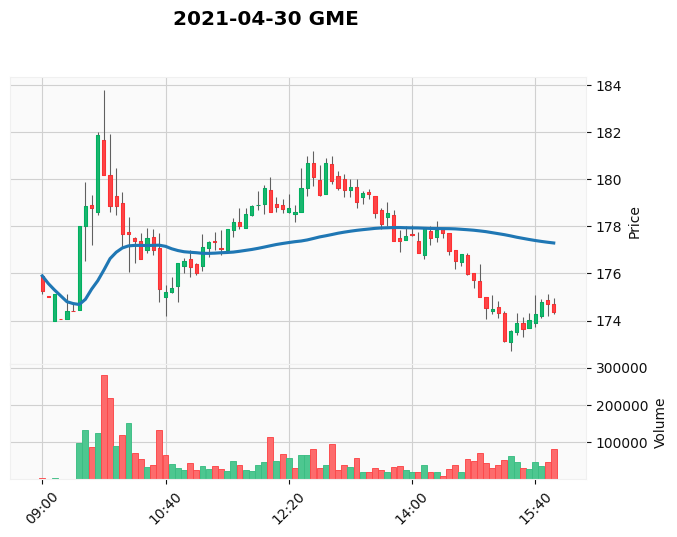

Period's starting TWAP value: 175.9
Period's ending TWAP value: 176.90267708333332
Purchased one share for 175.9
Purchased one share for 175.05
Purchased one share for 174.0
Purchased one share for 174.06
Purchased one share for 175.9
Purchased one share for 175.05
Purchased one share for 174.0
Purchased one share for 174.06
Purchased one share for 174.06
Purchased one share for 174.4
Purchased one share for 174.45
Purchased one share for 178.0
Purchased one share for 174.06
Purchased one share for 174.4
Purchased one share for 174.45
Purchased one share for 178.0
Purchased one share for 178.89
Purchased one share for 178.62
Purchased one share for 178.89
Purchased one share for 178.62


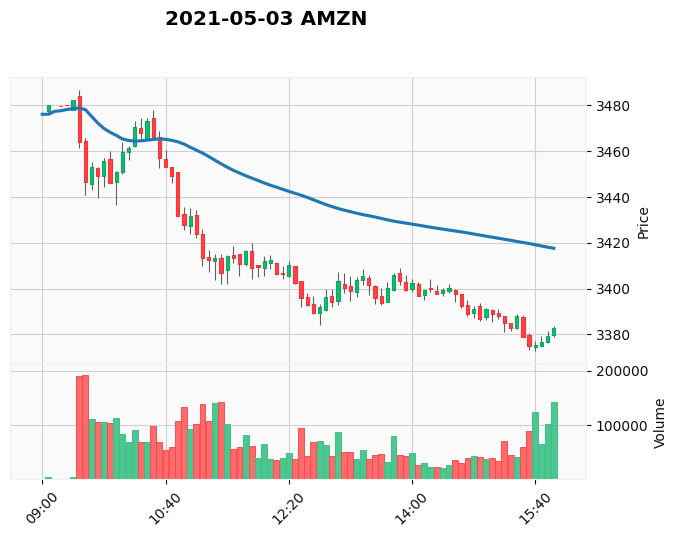

In [ ]:
def main(argv):
    
    cores = int(argv[-1])
    
    argv.pop()

    for stock in argv:
        multi(stock, 1000, cores, add_vwap=1, add_twap=1)

#Default execution
if __name__ == '__main__':
    #list of tickers
    args = ['TSLA','AAPL','GME','AMZN','MSFT']
    cores = '1';
    
    args.append(cores)
    
    #call main
    main(args)
